the code here is built upon the dbscan.ipynb code structure.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from utils import *
import os
sns.set(style='whitegrid')  # Set seaborn style for better visuals


In [17]:
%pip install hdbscan

Note: you may need to restart the kernel to use updated packages.


In [18]:
import hdbscan

### HDBSCAN Logic: 

In [19]:
def run_hdbscan(X, y_true, min_cluster_size=5, min_samples=None, title='',
                metric='euclidean'):
    # Standardize features
    X_scaled = StandardScaler().fit_transform(X)

    # Run HDBSCAN
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples,
                                metric=metric)
    y_pred = clusterer.fit_predict(X_scaled)

    # Number of clusters and noise points
    n_clusters = len(set(y_pred)) - (1 if -1 in y_pred else 0)  # number of clusters excluding noise 'cluster'
    n_noise = list(y_pred).count(-1)

    # Visualization
    if X_scaled.shape[1] == 2:
        visualize_clustering_2D(X_scaled, y_pred, y_true, title=title)
    elif X_scaled.shape[1] >= 3:
        visualize_clustering_3D(X_scaled, y_pred, y_true, title=title)
    else:
        print("Data has less than 2 dimensions; cannot visualize")

    print(f"Estimated number of clusters: {n_clusters}")
    print(f"Estimated number of noise points: {n_noise}")
    print("---------------------------------------------")

    # Evaluation Metrics
    evaluate_clustering(X_scaled, y_pred, y_true, n_clusters, title=title)

    return clusterer

### Tuning Function (for gridsearch):

In [20]:
def tune_hdbscan_params(X, y_true, min_cluster_size_values, min_samples_values,metric='euclidean'):
    # Standardize features
    X_scaled = StandardScaler().fit_transform(X)

    best_ami = -1
    best_params = {'min_cluster_size': None, 'min_samples': None}

    for min_cluster_size in min_cluster_size_values:
        for min_samples in min_samples_values:
            # Run HDBSCAN
            clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, 
                                        metric=metric)
            y_pred = clusterer.fit_predict(X_scaled)

            # Number of clusters and noise points
            n_clusters = len(set(y_pred)) - (1 if -1 in y_pred else 0)
            # Skip if only one cluster or all noise
            if n_clusters <= 1:
                continue

            # Evaluate clustering silently
            ami, _, _ = evaluate_clustering(X_scaled, y_pred, y_true, n_clusters, verbose=False)

            # Keep track of best parameters
            if ami > best_ami:
                best_ami = ami
                best_params['min_cluster_size'] = min_cluster_size
                best_params['min_samples'] = min_samples

    return best_params


In [21]:
# prep datasets
datasets_dir = 'datasets'
datasets = [
    ('isotropic_blobs.csv', {}, 'Isotropic Gaussian Blobs'),
    ('anisotropic_blobs.csv', {}, 'Anisotropic Gaussian Blobs'),
    ('moons_circles.csv', {}, 'Moons and Circles'),
    ('overlapping_clusters.csv', {}, 'Overlapping Clusters'),
    ('high_dimensional_data.csv', {}, 'High-Dimensional Data with Noise')
]


#### Driver Code: 


Processing Isotropic Gaussian Blobs...
Best parameters for Isotropic Gaussian Blobs: min_cluster_size=10, min_samples=3


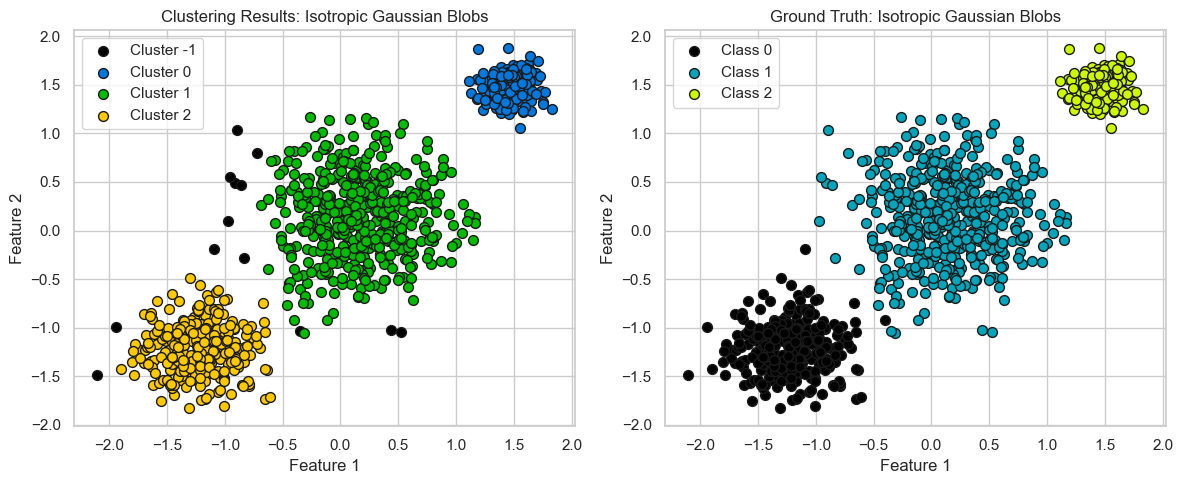

Estimated number of clusters: 3
Estimated number of noise points: 13
---------------------------------------------
Isotropic Gaussian Blobs
Adjusted Mutual Information: 0.9589
V-measure: 0.9590

Processing Anisotropic Gaussian Blobs...
Best parameters for Anisotropic Gaussian Blobs: min_cluster_size=5, min_samples=9


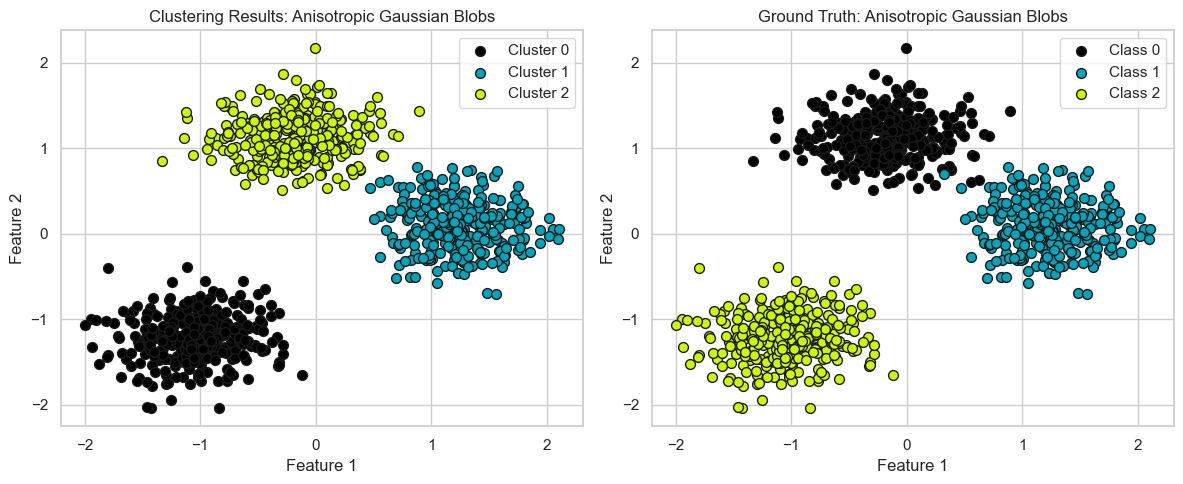

Estimated number of clusters: 3
Estimated number of noise points: 0
---------------------------------------------
Anisotropic Gaussian Blobs
Adjusted Mutual Information: 0.9826
V-measure: 0.9827

Processing Moons and Circles...
Best parameters for Moons and Circles: min_cluster_size=5, min_samples=5


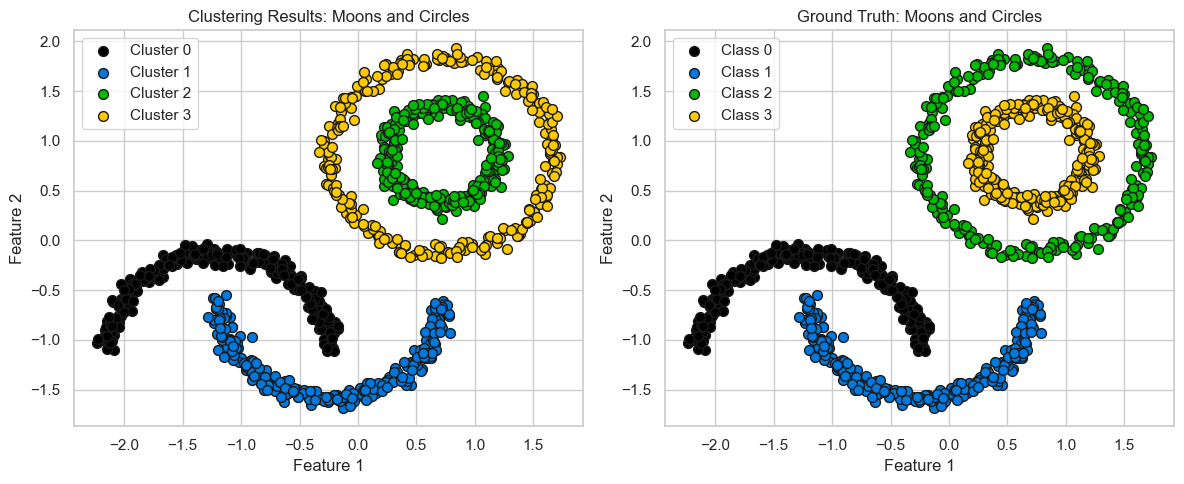

Estimated number of clusters: 4
Estimated number of noise points: 0
---------------------------------------------
Moons and Circles
Adjusted Mutual Information: 1.0000
V-measure: 1.0000

Processing Overlapping Clusters...
Best parameters for Overlapping Clusters: min_cluster_size=30, min_samples=1


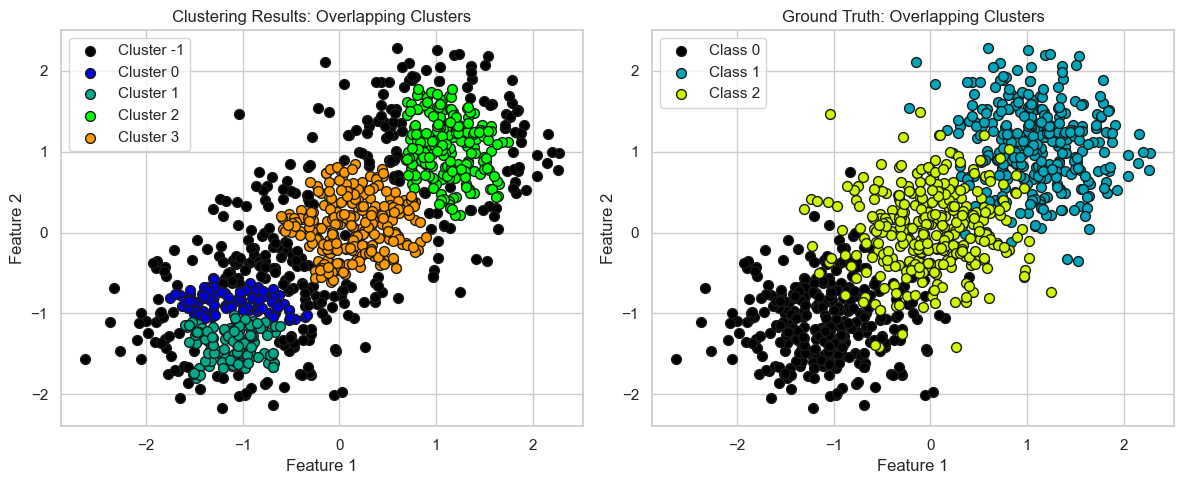

Estimated number of clusters: 4
Estimated number of noise points: 332
---------------------------------------------
Overlapping Clusters
Adjusted Mutual Information: 0.4567
V-measure: 0.4584

Processing High-Dimensional Data with Noise...
Best parameters for High-Dimensional Data with Noise: min_cluster_size=5, min_samples=1
Data has been reduced to 3D using PCA for visualization.


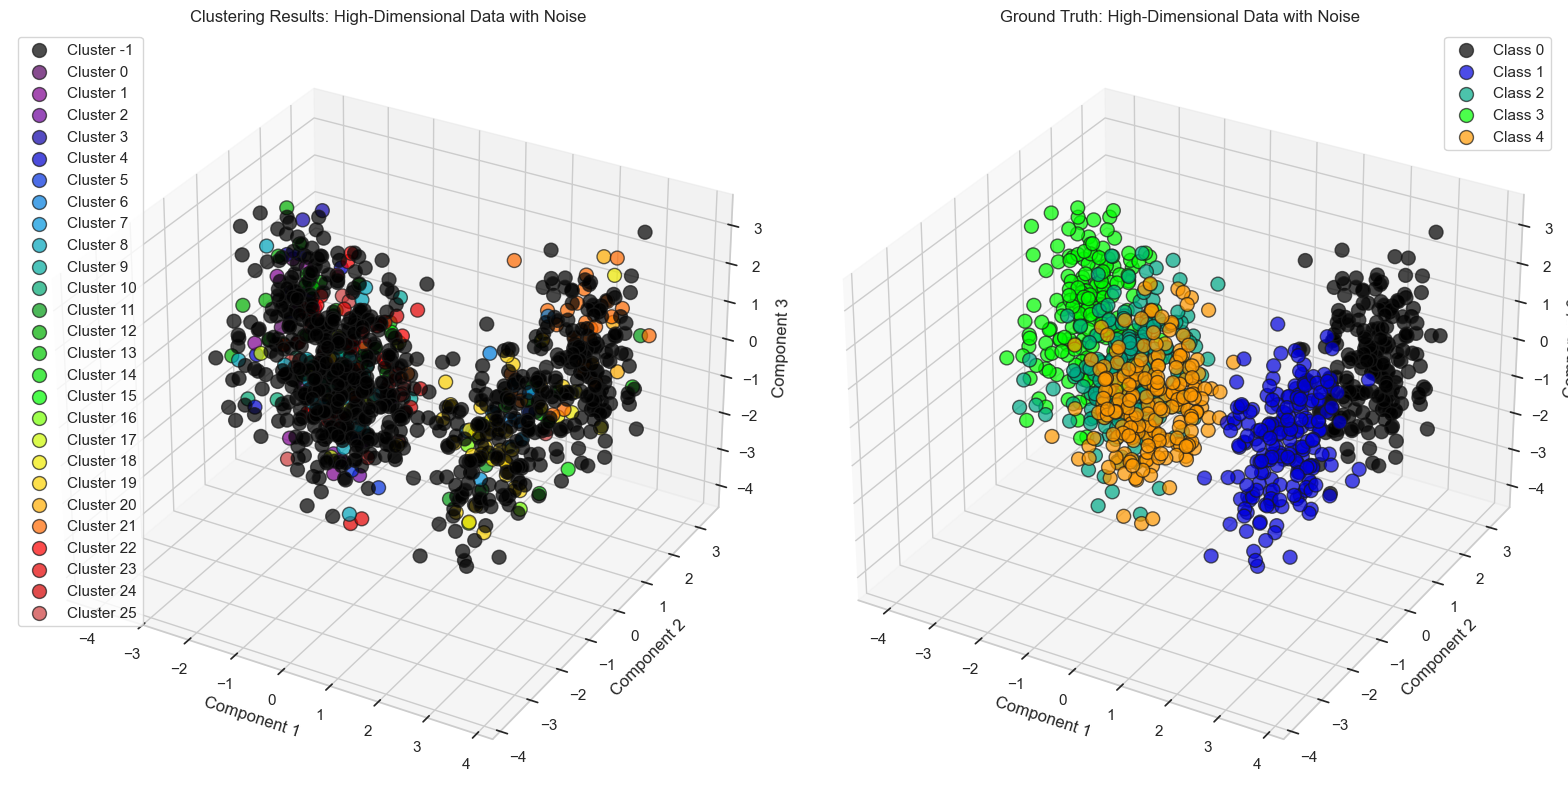

Estimated number of clusters: 26
Estimated number of noise points: 737
---------------------------------------------
High-Dimensional Data with Noise
Adjusted Mutual Information: 0.1713
V-measure: 0.2055


In [22]:
for filename, params, title in datasets:
    print(f"\nProcessing {title}...")
    filepath = os.path.join(datasets_dir, filename)
    X, y_true = load_dataset(filepath)

    # Define parameter ranges (educated guesses for now.)
    if title == 'Isotropic Gaussian Blobs':
        min_cluster_size_values = range(5, 50, 5)
        min_samples_values = range(1, 10, 2)
    elif title == 'Anisotropic Gaussian Blobs':
        min_cluster_size_values = range(5, 50, 5)
        min_samples_values = range(1, 10, 2)
    elif title == 'Moons and Circles':
        min_cluster_size_values = range(5, 50, 5)
        min_samples_values = range(1, 10, 2)
    elif title == 'Overlapping Clusters':
        min_cluster_size_values = range(5, 50, 5)
        min_samples_values = range(1, 10, 2)
    elif title == 'High-Dimensional Data with Noise':
        min_cluster_size_values = range(5, 100, 10)
        min_samples_values = range(1, 20, 4)
    else:
        min_cluster_size_values = range(5, 50, 5)
        min_samples_values = range(1, 10, 2)

    # Tune hyperparameters
    best_params = tune_hdbscan_params(X, y_true, min_cluster_size_values, min_samples_values)

    if best_params['min_cluster_size'] is not None:
        # Update params with best parameters
        params['min_cluster_size'] = best_params['min_cluster_size']
        params['min_samples'] = best_params['min_samples']
        print(f"Best parameters for {title}: min_cluster_size={params['min_cluster_size']}, min_samples={params['min_samples']}")
    else:
        # Use default parameters if no best parameters found
        params['min_cluster_size'] = min_cluster_size_values[0]
        params['min_samples'] = min_samples_values[0]
        print(f"No suitable parameters found for {title}. Using default parameters.")

    # Run HDBSCAN with best parameters and visualize results as before
    clusterer = run_hdbscan(X, y_true, min_cluster_size=params['min_cluster_size'], min_samples=params['min_samples'], title=title)


### UMAP Dimension Reduction

In [23]:
# Import UMAP
import umap.umap_ as umap

# Load high-dimensional dataset
dataset_name = 'High-Dimensional Data with Noise'
filename = 'high_dimensional_data.csv'
filepath = os.path.join(datasets_dir, filename)
X_high_dim, y_true_high_dim = load_dataset(filepath)

# Apply UMAP to reduce dimensionality to 3D
n_components = 12
umap_reducer = umap.UMAP(n_components=n_components, random_state=42)
X_reduced = umap_reducer.fit_transform(X_high_dim)

print(f"Original shape: {X_high_dim.shape}")
print(f"Reduced shape: {X_reduced.shape}")

c:\Users\sharm\anaconda3\envs\virtual\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Original shape: (1000, 50)
Reduced shape: (1000, 12)


### Run HDBSCAN on UMAP reduced data

Best parameters for High-Dimensional Data with Noise after UMAP: min_cluster_size=5, min_samples=5
Data has been reduced to 3D using PCA for visualization.


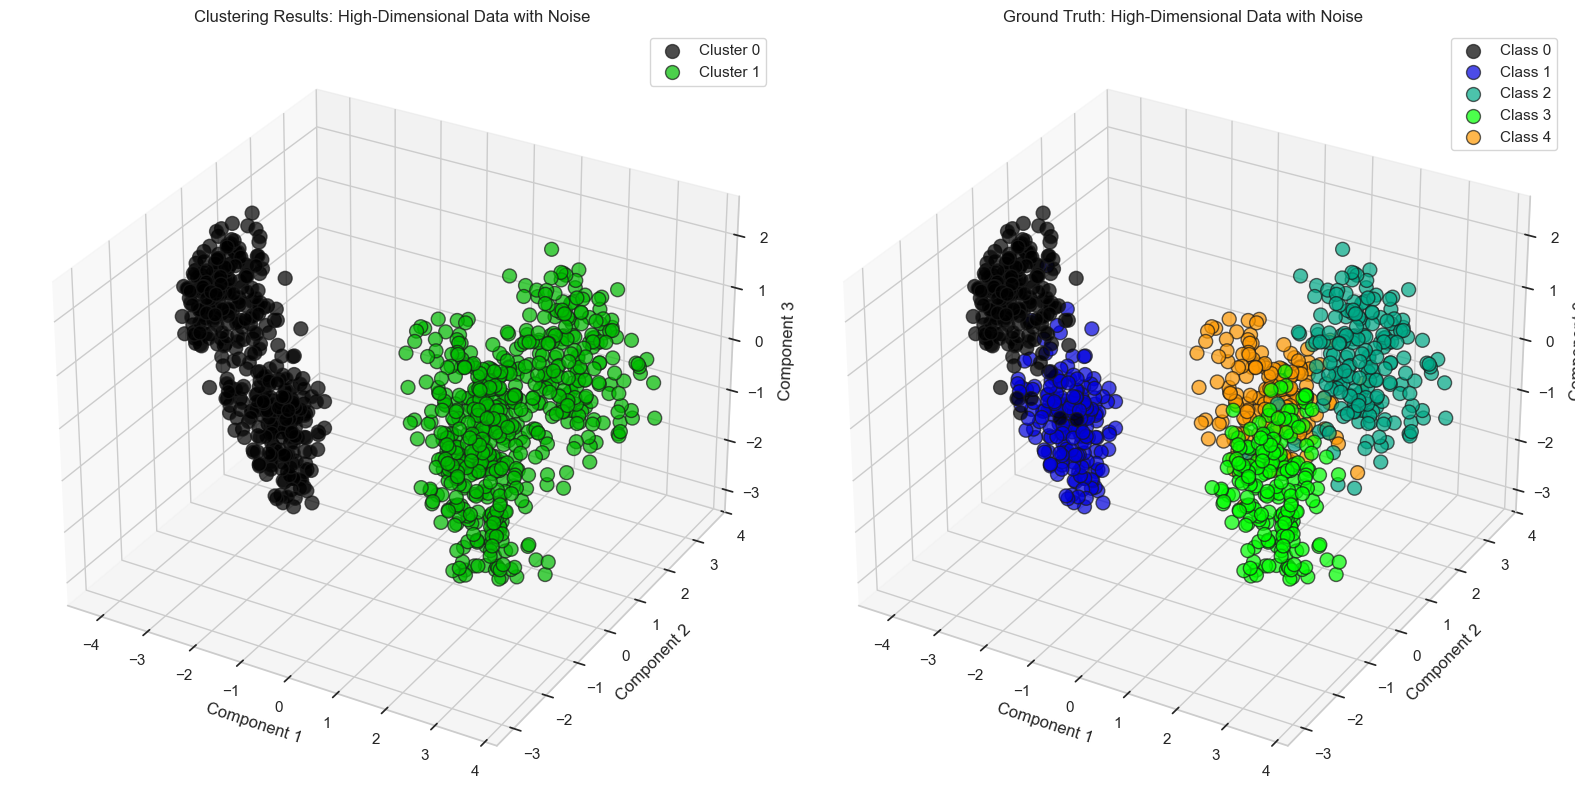

Estimated number of clusters: 2
Estimated number of noise points: 0
---------------------------------------------
High-Dimensional Data with Noise
Adjusted Mutual Information: 0.5890
V-measure: 0.5897


In [24]:
# Define parameter ranges for tuning
min_cluster_size_values = range(5, 100, 10)
min_samples_values = range(1, 40, 4)

# Tune hyperparameters on reduced data
best_params = tune_hdbscan_params(X_reduced, y_true_high_dim, min_cluster_size_values, min_samples_values)
                                  # metric='cosine') cosine not supported with HDBSCAN.

if best_params['min_cluster_size'] is not None:
    # Update params with best parameters
    params = {}
    params['min_cluster_size'] = best_params['min_cluster_size']
    params['min_samples'] = best_params['min_samples']
    print(f"Best parameters for {dataset_name} after UMAP: min_cluster_size={params['min_cluster_size']}, min_samples={params['min_samples']}")
else:
    # Use default parameters if no best parameters found
    params = {'min_cluster_size': min_cluster_size_values[0], 'min_samples': min_samples_values[0]}
    print(f"No suitable parameters found for {dataset_name}. Using default parameters.")

# Run HDBSCAN with best parameters and visualize results
clusterer = run_hdbscan(X_reduced, y_true_high_dim, min_cluster_size=params['min_cluster_size'], min_samples=params['min_samples'], title=dataset_name)
                        # metric='cosine')